# Demo of Unbalanced JEs and Completness Test

In [1]:
# Imports
import dask
import dask.dataframe as dd
from dask.distributed import Client

In [2]:
# Start DASK
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56396,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:56407,Total threads: 4
Dashboard: http://127.0.0.1:56414/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:56399,


## Read in Data

In [3]:
# Read TB data
source_tb = '../data/trail_balance.parquet'
df_tb = dd.read_parquet(source_tb)

In [4]:
# Read GL Data (23,5469 Rows)
source_gl = '../data/general_ledger_235_469.parquet'
df_gl = dd.read_parquet(source_gl)

In [5]:
# Nothing is read in yet, just a placeholding for planning.
df_tb

,TB_Fiscal_Year,TB_Business_Unit_Code,TB_Account_Number,TB_Amount_Opening_Balance,TB_Amount_Ending_Balance
npartitions=1,,,,,
,string,string,string,float64,float64
,...,...,...,...,...


In [6]:
df_gl

,GL_Journal_ID,GL_Journal_ID_Line_Number,GL_Fiscal_Year,GL_Effective_Date,GL_Business_Unit_Code,GL_Account_Number,GL_Local_Amount
npartitions=2,,,,,,,
,string,string,string,string,string,string,float64
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...


## Find Unblanced JE

In [7]:
# Get JE totals
df_gl_je_total = df_gl.groupby(by='GL_Journal_ID')['GL_Local_Amount'].sum()

In [8]:
# Get Unbalanced JEs
df_gl_unbalanced_je = df_gl_je_total[df_gl_je_total.abs().round(2) > 0]

In [9]:
# Get Unbalanced Lines
df_gl_unbalanced_lines = dd.merge(
    left=df_gl,
    right=df_gl_unbalanced_je,
    how='inner',
    left_on='GL_Journal_ID',
    right_index=True,
    suffixes=(None,'_y'),
)

In [10]:
# Filter just for the columns we want
columns = ['GL_Journal_ID','GL_Effective_Date','GL_Journal_ID_Line_Number','GL_Account_Number', 'GL_Local_Amount']
df_unbalanced_lines_report = df_gl_unbalanced_lines[columns]

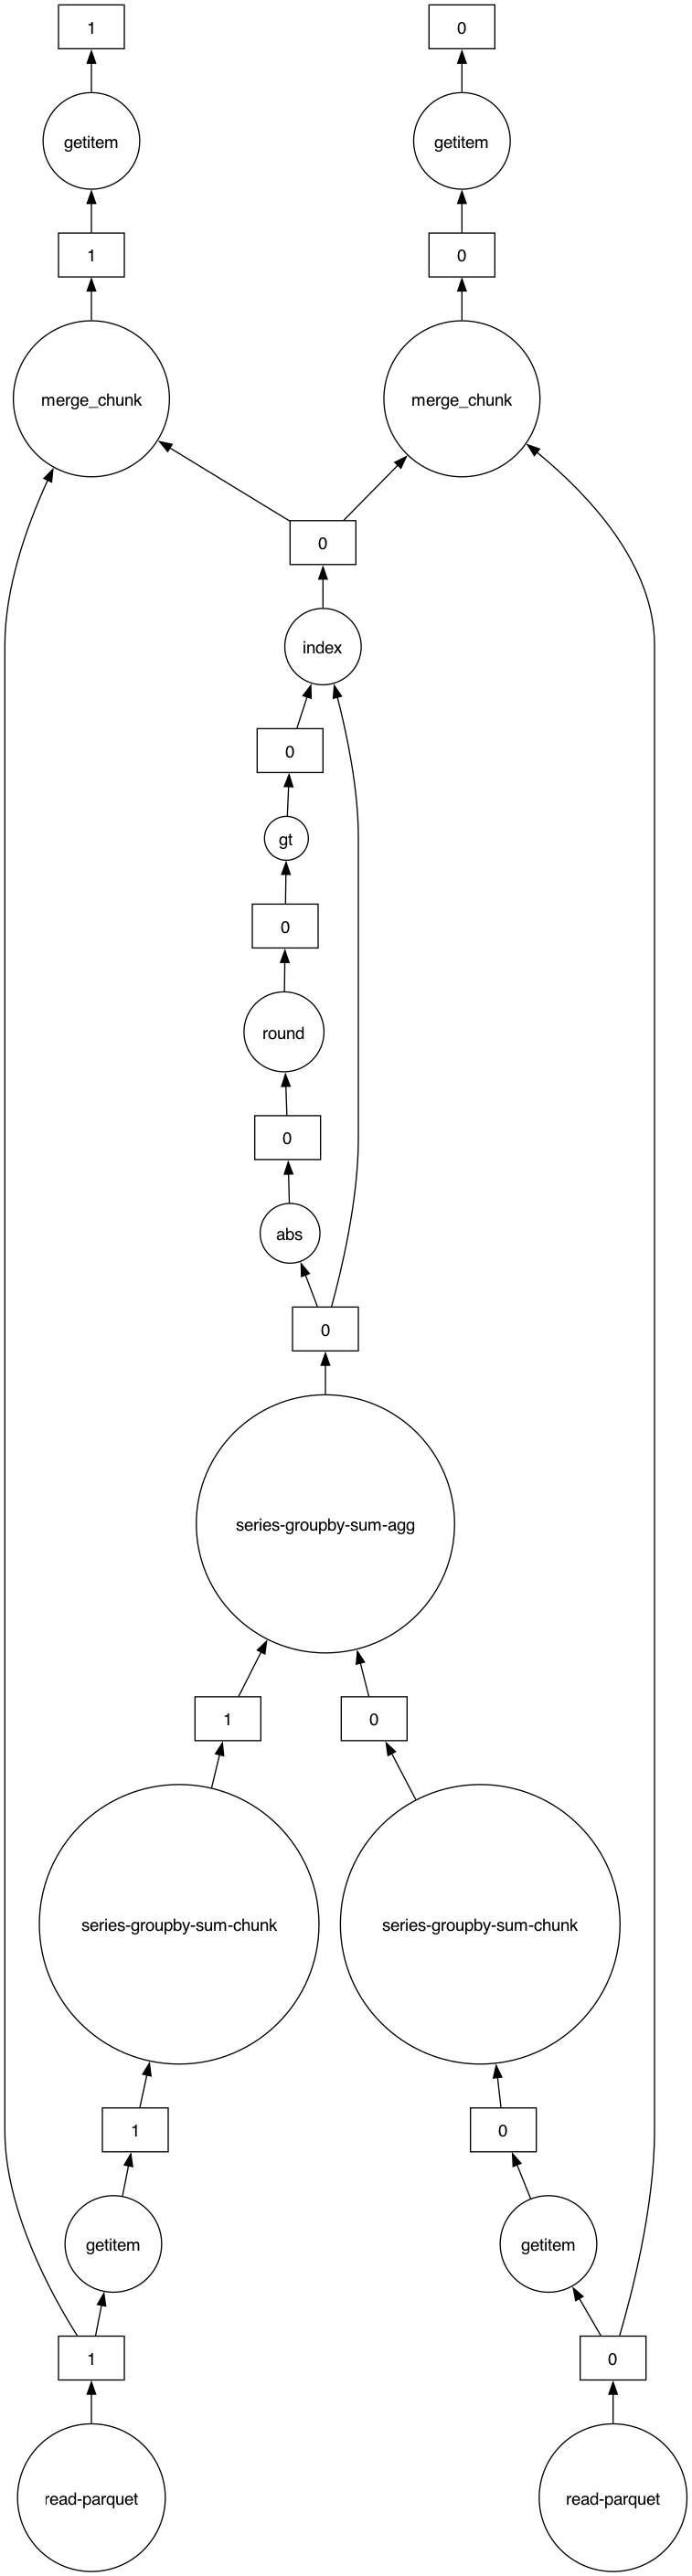

In [11]:
# What is DASK going to do?
df_unbalanced_lines_report.visualize()

In [12]:
# Lets get a local copy so we can play with the data
df_unbalanced_lines_report_local = df_unbalanced_lines_report.compute()
df_unbalanced_lines_report_local

,GL_Journal_ID,GL_Effective_Date,GL_Journal_ID_Line_Number,GL_Account_Number,GL_Local_Amount
21,2004/01-3000-L6-0100003767,2004-01-02,001-0100003767-000001,0000176000,0.00
22,2004/01-3000-L6-0100003767,2004-01-02,002-0100003767-000002,0000176100,0.00
23,2004/01-3000-L6-0100003767,2004-01-02,003-0100003767-000003,0000176110,0.00
24,2004/01-3000-L6-0100003767,2004-01-02,004-0100003767-000004,0000176120,0.00
25,2004/01-3000-L6-0100003767,2004-01-02,005-0100003767-000005,0000176210,0.00
...,...,...,...,...,...
116196,2004/12-3000-L6-0100006969,2004-12-31,139-0100006969-000139,0000420000,0.00
116197,2004/12-3000-L6-0100006969,2004-12-31,140-0100006969-000140,0000465000,0.00
116198,2004/12-3000-L6-0100006969,2004-12-31,141-0100006969-000141,0000420000,0.00
116199,2004/12-3000-L6-0100006969,2004-12-31,142-0100006969-000142,0000465000,0.00


## Do a Completness Check 

In [13]:
# Summaraize GL by account number
gl_groupby_columns = ['GL_Fiscal_Year','GL_Business_Unit_Code','GL_Account_Number']
df_gl_by_account = df_gl.groupby(by=gl_groupby_columns)[['GL_Local_Amount']].sum().reset_index()

In [14]:
# Summaraize TB by account number
tb_groupby_columns = ['TB_Fiscal_Year','TB_Business_Unit_Code','TB_Account_Number']
tb_amount_columns = ['TB_Amount_Opening_Balance','TB_Amount_Ending_Balance']
df_tb_by_account = df_tb.groupby(by=tb_groupby_columns)[tb_amount_columns].sum().reset_index()

In [15]:
# Combine GL and TB data
df_gl_tb_by_account = dd.merge(
    left=df_gl_by_account,
    right=df_tb_by_account,
    how='outer',
    left_on=gl_groupby_columns,
    right_on=tb_groupby_columns,
)

In [16]:
# Compute any completness differances
df_gl_tb_by_account['Differance'] = (
    df_gl_tb_by_account['TB_Amount_Opening_Balance'] 
    + df_gl_tb_by_account['GL_Local_Amount'] 
    - df_gl_tb_by_account['TB_Amount_Ending_Balance']
)

In [17]:
# Filter just for the columns we want and cleanup column names
column_map = {
    'TB_Fiscal_Year': 'Fiscal_Year',
    'TB_Business_Unit_Code': 'Business_Unit_Code',
    'TB_Account_Number': 'Account_Number',
    'TB_Amount_Opening_Balance': 'Opening_Balance',
    'GL_Local_Amount': 'Activity',
    'TB_Amount_Ending_Balance': 'Ending_Balance',
    'Differance': 'Differance',
}

df_completness_report = df_gl_tb_by_account[list(column_map.keys())].rename(columns=column_map)

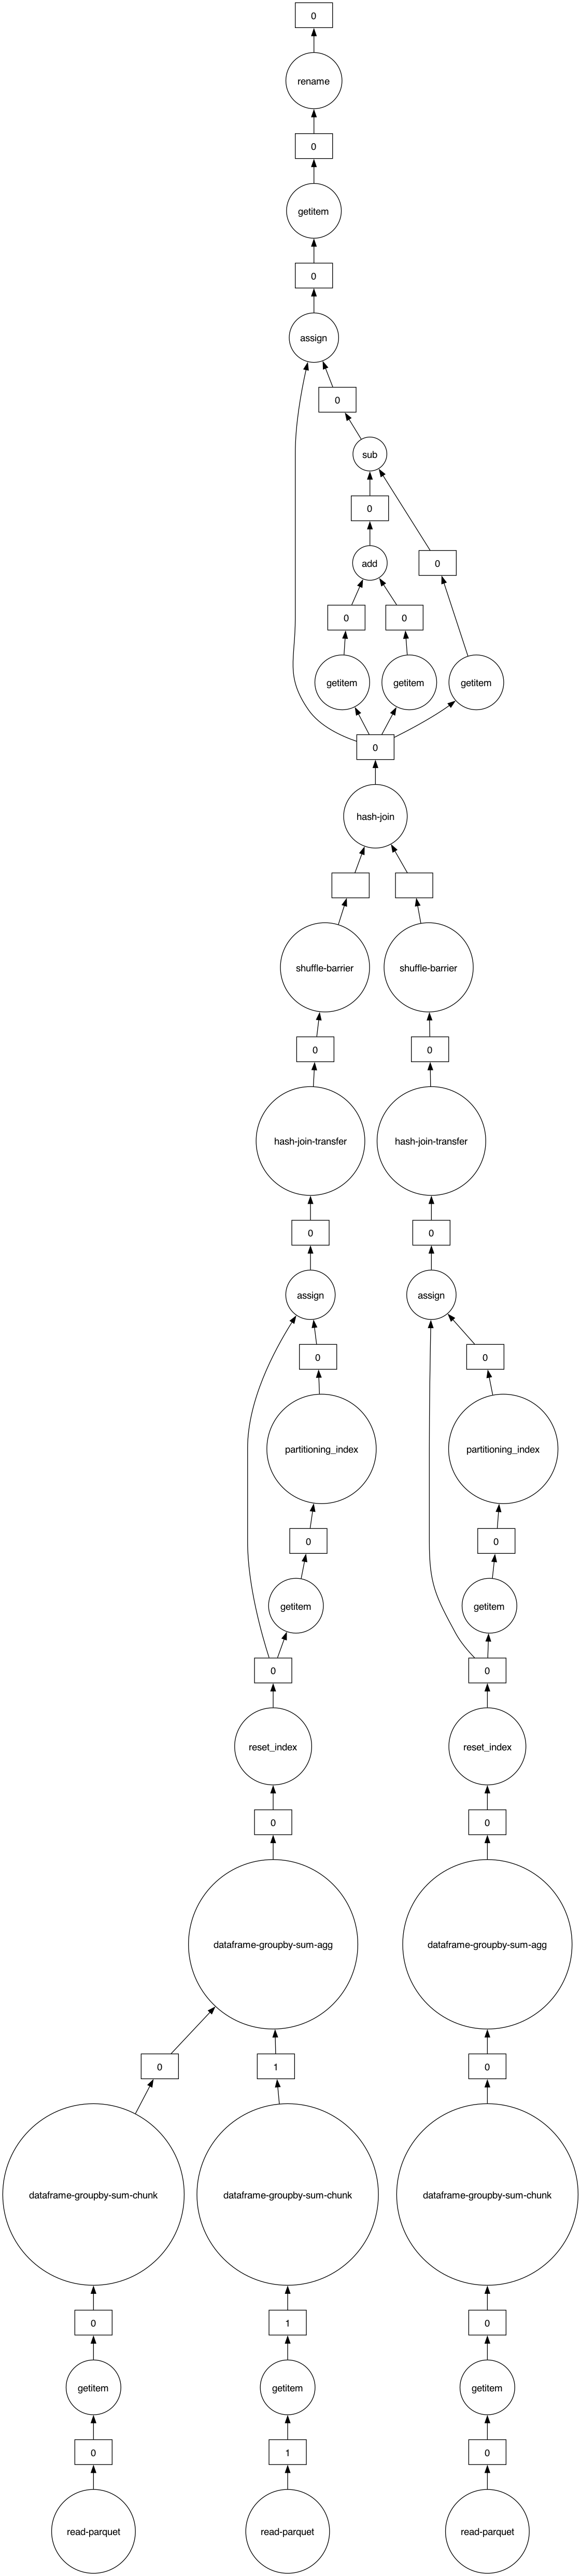

In [18]:
# What is DASK going to do?
df_completness_report.visualize()

In [19]:
# Lets get a local copy so we can play with the data
df_completness_report_local = df_completness_report.compute()
df_completness_report_local

,Fiscal_Year,Business_Unit_Code,Account_Number,Opening_Balance,Activity,Ending_Balance,Differance
0,2004,1000-0L,0000001010,-3.758600e+08,-1182825.0,-3.782257e+08,1182825.0
1,2004,1000-0L,0000011010,-1.505509e+08,-313234.0,-1.511773e+08,313234.0
2,2004,1000-0L,0000021010,-6.021756e+07,-88589.0,-6.039474e+07,88589.0
3,2004,1000-0L,0000078000,-5.670047e+07,62459.0,-5.657555e+07,-62459.0
4,2004,1000-0L,0000100100,4.797200e+05,-20.0,4.796800e+05,20.0
...,...,...,...,...,...,...,...
1148,2004,3000-L6,0000303000,0.000000e+00,NaN,0.000000e+00,NaN
1149,2004,3000-L6,0000304000,0.000000e+00,NaN,0.000000e+00,NaN
1150,2004,3000-L6,0000793000,0.000000e+00,NaN,0.000000e+00,NaN
1151,2004,3000-L6,0000900000,0.000000e+00,NaN,0.000000e+00,NaN


## Run Unblanced JE & Do a Completness Check

To be more effent, don't read the data in twice and run Unblanced JE and Completness seperatly.  Run them both at the same time so the same data does not need to be read in twice

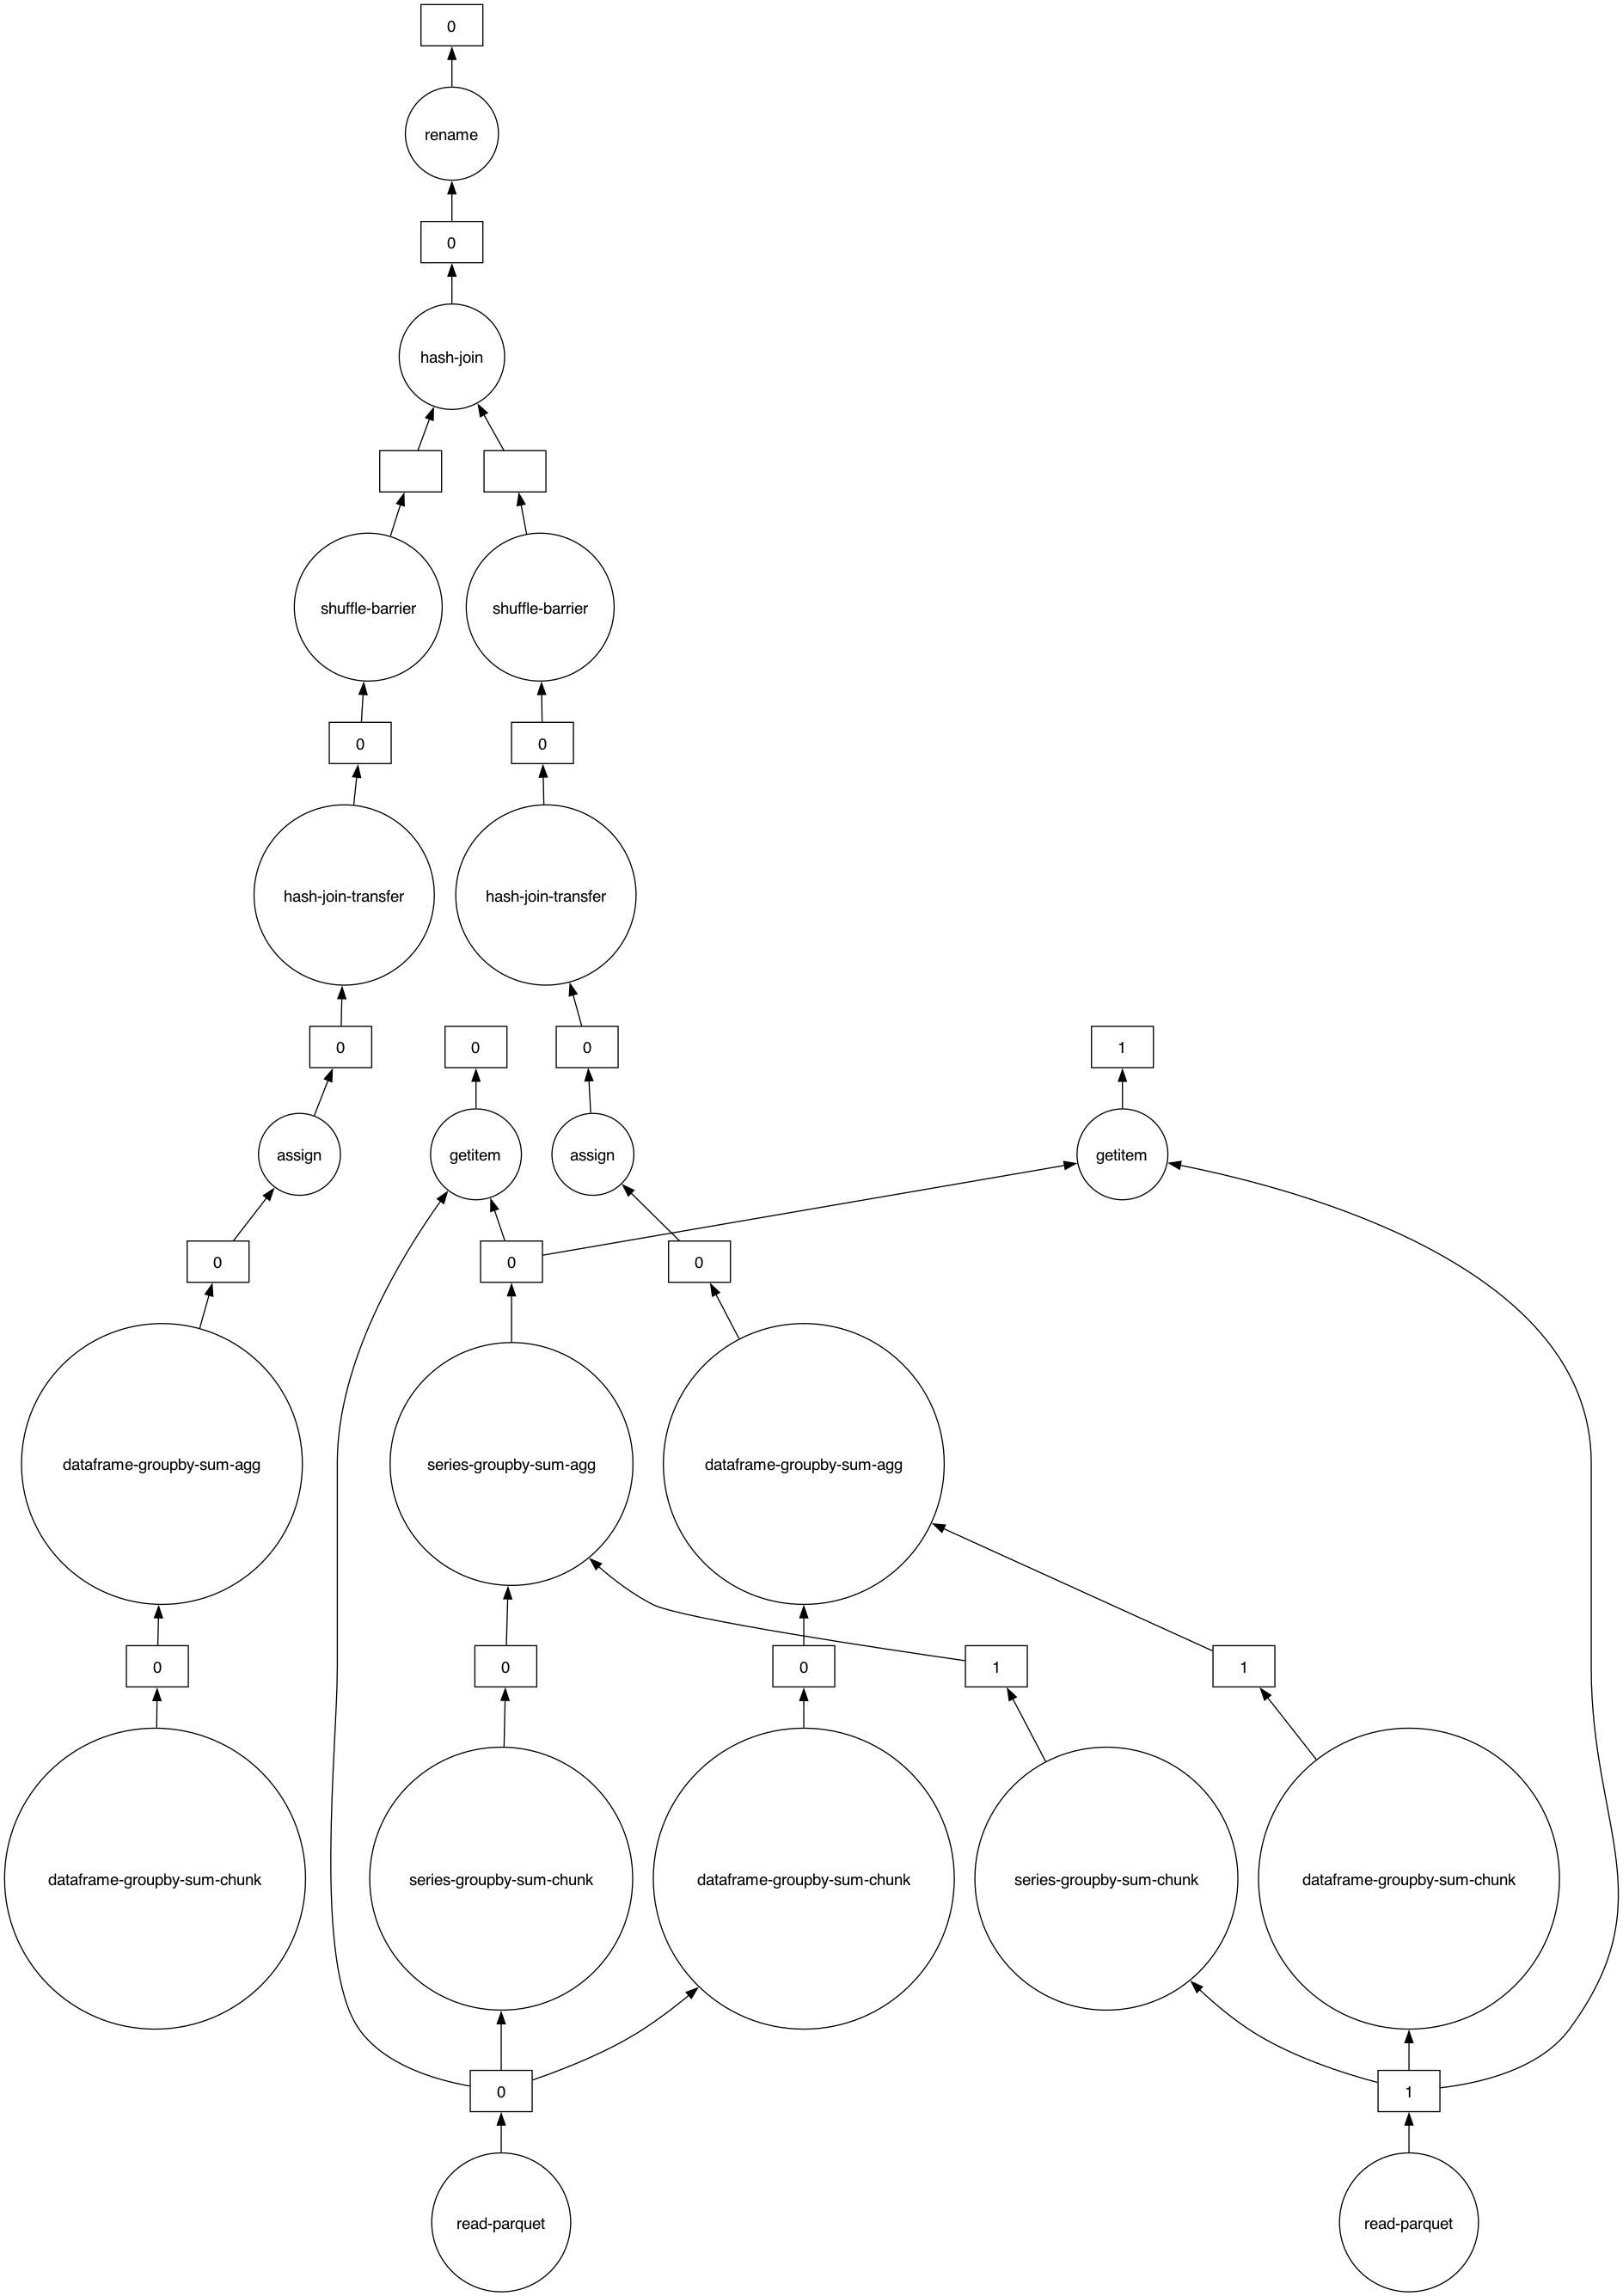

In [20]:
# View plan to compute Unblanced JE and Completness together (simplify for readability)
dask.visualize(
    df_unbalanced_lines_report,
    df_completness_report,
    optimize_graph=True,
)

In [21]:
# Compute Unblanced JE and Completness at once
df_unbalanced_lines_report_local, df_completness_report_local = dask.compute(
    df_unbalanced_lines_report,
    df_completness_report,
)

In [22]:
# View unbalanced JEs
df_unbalanced_lines_report_local

,GL_Journal_ID,GL_Effective_Date,GL_Journal_ID_Line_Number,GL_Account_Number,GL_Local_Amount
21,2004/01-3000-L6-0100003767,2004-01-02,001-0100003767-000001,0000176000,0.00
22,2004/01-3000-L6-0100003767,2004-01-02,002-0100003767-000002,0000176100,0.00
23,2004/01-3000-L6-0100003767,2004-01-02,003-0100003767-000003,0000176110,0.00
24,2004/01-3000-L6-0100003767,2004-01-02,004-0100003767-000004,0000176120,0.00
25,2004/01-3000-L6-0100003767,2004-01-02,005-0100003767-000005,0000176210,0.00
...,...,...,...,...,...
116196,2004/12-3000-L6-0100006969,2004-12-31,139-0100006969-000139,0000420000,0.00
116197,2004/12-3000-L6-0100006969,2004-12-31,140-0100006969-000140,0000465000,0.00
116198,2004/12-3000-L6-0100006969,2004-12-31,141-0100006969-000141,0000420000,0.00
116199,2004/12-3000-L6-0100006969,2004-12-31,142-0100006969-000142,0000465000,0.00


In [23]:
# View Complteness
df_completness_report_local

,Fiscal_Year,Business_Unit_Code,Account_Number,Opening_Balance,Activity,Ending_Balance,Differance
0,2004,1000-0L,0000001010,-3.758600e+08,-1182825.0,-3.782257e+08,1182825.0
1,2004,1000-0L,0000011010,-1.505509e+08,-313234.0,-1.511773e+08,313234.0
2,2004,1000-0L,0000021010,-6.021756e+07,-88589.0,-6.039474e+07,88589.0
3,2004,1000-0L,0000078000,-5.670047e+07,62459.0,-5.657555e+07,-62459.0
4,2004,1000-0L,0000100100,4.797200e+05,-20.0,4.796800e+05,20.0
...,...,...,...,...,...,...,...
1148,2004,3000-L6,0000303000,0.000000e+00,NaN,0.000000e+00,NaN
1149,2004,3000-L6,0000304000,0.000000e+00,NaN,0.000000e+00,NaN
1150,2004,3000-L6,0000793000,0.000000e+00,NaN,0.000000e+00,NaN
1151,2004,3000-L6,0000900000,0.000000e+00,NaN,0.000000e+00,NaN


# Stress Testing with 100 Million Rows of Data

## Read in Data (100M)

In [24]:
# Read TB data
df_tb = dd.read_parquet('../data/trail_balance.parquet')

# Read GL Data (100,000,000 Rows)
df_gl = dd.read_parquet('../data/general_ledger_100_074_325.parquet')

## Find Unblanced JE (100M)

In [25]:
# Get JE totals
df_gl_je_total = df_gl.groupby(by='GL_Journal_ID')['GL_Local_Amount'].sum()

# Get Unbalanced JEs
df_gl_unbalanced_je = df_gl_je_total[df_gl_je_total.abs().round(2) > 0]

# Get Unbalanced Lines
df_gl_unbalanced_lines = dd.merge(
    left=df_gl,
    right=df_gl_unbalanced_je,
    how='inner',
    left_on='GL_Journal_ID',
    right_index=True,
    suffixes=(None,'_y'),
)

# Filter just for the columns we want
columns = ['GL_Journal_ID','GL_Effective_Date','GL_Journal_ID_Line_Number','GL_Account_Number', 'GL_Local_Amount']
df_unbalanced_lines_report = df_gl_unbalanced_lines[columns]

## Do a Completness Check  (100M)

In [26]:
# Summaraize GL by account number
gl_groupby_columns = ['GL_Fiscal_Year','GL_Business_Unit_Code','GL_Account_Number']
df_gl_by_account = df_gl.groupby(by=gl_groupby_columns)[['GL_Local_Amount']].sum().reset_index()

# Summaraize TB by account number
tb_groupby_columns = ['TB_Fiscal_Year','TB_Business_Unit_Code','TB_Account_Number']
tb_amount_columns = ['TB_Amount_Opening_Balance','TB_Amount_Ending_Balance']
df_tb_by_account = df_tb.groupby(by=tb_groupby_columns)[tb_amount_columns].sum().reset_index()

# Combine GL and TB data
df_gl_tb_by_account = dd.merge(
    left=df_gl_by_account,
    right=df_tb_by_account,
    how='outer',
    left_on=gl_groupby_columns,
    right_on=tb_groupby_columns,
)

# Compute any completness differances
df_gl_tb_by_account['Differance'] = (
    df_gl_tb_by_account['TB_Amount_Opening_Balance'] 
    + df_gl_tb_by_account['GL_Local_Amount'] 
    - df_gl_tb_by_account['TB_Amount_Ending_Balance']
)

# Filter just for the columns we want and cleanup column names
column_map = {
    'TB_Fiscal_Year': 'Fiscal_Year',
    'TB_Business_Unit_Code': 'Business_Unit_Code',
    'TB_Account_Number': 'Account_Number',
    'TB_Amount_Opening_Balance': 'Opening_Balance',
    'GL_Local_Amount': 'Activity',
    'TB_Amount_Ending_Balance': 'Ending_Balance',
    'Differance': 'Differance',
}

df_completness_report = df_gl_tb_by_account[list(column_map.keys())].rename(columns=column_map)

## Run Unblanced JE & Do a Completness Check (100M)

In [27]:
%%time
# Compute Unblanced JE and Completness
df_unbalanced_lines_report_local, df_completness_report_local = dask.compute(
    df_unbalanced_lines_report,
    df_completness_report,
)

CPU times: user 14.3 s, sys: 4.67 s, total: 19 s
Wall time: 36.5 s


In [28]:
# View unbalanced JEs
df_unbalanced_lines_report_local

,GL_Journal_ID,GL_Effective_Date,GL_Journal_ID_Line_Number,GL_Account_Number,GL_Local_Amount
21,2004/01-3000-L6-0100003767,2004-01-02,001-0100003767-000001,0000176000,0.00
22,2004/01-3000-L6-0100003767,2004-01-02,002-0100003767-000002,0000176100,0.00
23,2004/01-3000-L6-0100003767,2004-01-02,003-0100003767-000003,0000176110,0.00
24,2004/01-3000-L6-0100003767,2004-01-02,004-0100003767-000004,0000176120,0.00
25,2004/01-3000-L6-0100003767,2004-01-02,005-0100003767-000005,0000176210,0.00
...,...,...,...,...,...
116196,2004/12-3000-L6-0100006969,2004-12-31,139-0100006969-000139,0000420000,0.00
116197,2004/12-3000-L6-0100006969,2004-12-31,140-0100006969-000140,0000465000,0.00
116198,2004/12-3000-L6-0100006969,2004-12-31,141-0100006969-000141,0000420000,0.00
116199,2004/12-3000-L6-0100006969,2004-12-31,142-0100006969-000142,0000465000,0.00


In [29]:
# View Complteness
df_completness_report_local

,Fiscal_Year,Business_Unit_Code,Account_Number,Opening_Balance,Activity,Ending_Balance,Differance
0,2004,1000-0L,0000001010,-3.758600e+08,-502700625.0,-3.782257e+08,-500334975.0
1,2004,1000-0L,0000011010,-1.505509e+08,-133124450.0,-1.511773e+08,-132497982.0
2,2004,1000-0L,0000021010,-6.021756e+07,-37650325.0,-6.039474e+07,-37473147.0
3,2004,1000-0L,0000078000,-5.670047e+07,26545075.0,-5.657555e+07,26420157.0
4,2004,1000-0L,0000100100,4.797200e+05,-8500.0,4.796800e+05,-8460.0
...,...,...,...,...,...,...,...
1148,2004,3000-L6,0000303000,0.000000e+00,NaN,0.000000e+00,NaN
1149,2004,3000-L6,0000304000,0.000000e+00,NaN,0.000000e+00,NaN
1150,2004,3000-L6,0000793000,0.000000e+00,NaN,0.000000e+00,NaN
1151,2004,3000-L6,0000900000,0.000000e+00,NaN,0.000000e+00,NaN


## Business Case: What issue does this address?
We were just able to process 100 million rows of data on my local laptop with no issues around the volume of the data, the limited number of cores, or the limited amout of RAM.

## Turn DASK off

In [30]:
client.shutdown()